<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Exercise_Imbalance_data_stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exercise** `Imbalanced data` - Stroke prediction

📘 **Instruction**

**Study case** `dataset stroke.csv`

Find the best model and hyperparameters to predict whether a patient has a stroke.

1. Perform EDA (Exploratory Data Analysis) to understand the dataset.

2. Perform preprocessing on features if needed.

3. Perform modeling using Logistic Regression, KNN, and Decision Tree.

Candidate Algorithms:

  * logreg = LogisticRegression(solver='liblinear', random_state=0)
  * knn = KNeighborsClassifier(n_neighbors=5)
  * tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)


4. Choose the best model based on the results of cross-validation among the three models above.

5. Define the benchmark model by applying imbalanced data treatment (e.g., SMOTE or other methods).

6. Perform hyperparameter tuning on the selected model.

7. Make predictions on the test set using the benchmark model (before hyperparameter tuning).

8. Make predictions on the test set using the tuned model.

9. Compare the performance of the model before and after tuning.

**Initial Setup**

In [1]:
# Install additional library
#!pip install category_encoders

In [2]:
# Importing required libraries

# Data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Splitting
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Preprocessing
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# Resampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# ML algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import recall_score, classification_report, confusion_matrix

## 🏢 **Business Understanding**

**Context**

Stroke is one of the leading causes of death and disability worldwide. Early detection of stroke risk is crucial for preventive healthcare. Using machine learning, we can predict the likelihood of a patient experiencing a stroke based on their demographic, health, and lifestyle data. This can help medical professionals prioritize patients at higher risk and take preventive action.

**Problem Statement**

How can we build a reliable machine learning model to predict whether a patient is at risk of stroke based on their health and lifestyle features?

**Goals**

* To identify the best predictive model for stroke detection.

* To compare multiple classification algorithms (Logistic Regression, KNN, Decision Tree).

* To improve prediction performance by handling class imbalance and applying hyperparameter tuning.

* To provide a benchmark model and an optimized (tuned) model for stroke prediction.

**Analytic Approach**

* Perform Exploratory Data Analysis (EDA) to understand the distribution of features and detect missing values or anomalies.

* Apply data preprocessing (encoding categorical variables, handling missing values, scaling features, balancing data).

* Train and evaluate three candidate models: Logistic Regression, KNN, and Decision Tree.

* Use cross-validation to compare models and select the best one.

* Handle imbalanced data using SMOTE or similar techniques to ensure fair training.

* Perform hyperparameter tuning on the chosen model to improve performance.

* Compare model performance before and after tuning using evaluation metrics.

* Provide final insights and recommendations for applying the model in stroke prediction.

**Evaluation Metric**

Since our main focus is on patients who suffer from stroke, the target is defined as follows:

Target:

* 0: Patient does not have a stroke

* 1: Patient has a stroke

There will be two types of errors:

* Type I Error (False Positive):
  * Patient who actually does not have a stroke but is predicted to have one.

  * Consequence: Mistakes in prescribing medication or treatment for the patient.

* Type II Error (False Negative):

  * Patient who actually has a stroke but is predicted not to have one.

  * Consequence: Delay in receiving treatment, which in the most severe cases may lead to death.

Based on these consequences, we consider that the impact of False Negatives is far more critical. Therefore, our primary goal is to build a model that can minimize the number of False Negatives.
As a result, the main evaluation metric we will use is Recall

**Data Understanding**

In [3]:
# Loading dataset
stroke_csv_url = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/stroke.csv'
data = pd.read_csv(stroke_csv_url)
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**Attribute Information**

| Attribute | Data Type | Description |
| --- | --- | --- |
|id |Integer | unique identifier |
|gender |Text | gender of patient (categorical: "Male","Female","Other") |
|age |Float | age of the patient |
|hypertension |Integer | 0 if the patient doesn't have hypertension, 1 if the patient has hypertension |
|heart_disease |Integer | 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease |
|ever_married |Text | ever married? (categorical: "no","yes") |
|work_type |Text | jobs (categorical: "children", "Govt_jov", "Never_worked", "Private", "Self-employed") |
|residence_type |Text | residence of patient (categorical: "Rural","Urban") |
|avg_glucose_level |Float | average glucose level in blood |
|bmi |Float | body mass index |
|smoking_status |Text | has smoke? (categorical: "formerly smoked", "never smoked", "smokes", "Unknown" [the information is unavailable]) |
|stroke |Integer | 1 if the patient had a stroke or 0 if not |

In [4]:
# Convert values of some columns
data['hypertension'] = np.where(data['hypertension']==1, "Yes", "No")
data['heart_disease'] = np.where(data['heart_disease']==1, "Yes", "No")
data['stroke'] = np.where(data['stroke']==1, "Yes", "No")

Initial Assesment

In [5]:
# Check data type, null values, and unique values ​​of each column
pd.DataFrame({
    'feature': data.columns.values,
    'data_type': data.dtypes.values,
    'null': data.isna().mean().values * 100,
    'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
    'n_unique': data.nunique().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,null,negative,n_unique,sample_unique
0,id,int64,0.000000,False,5110,"[9046, 51676, 31112, 60182, 1665, 56669, 53882..."
1,gender,object,0.000000,False,3,"[Male, Female, Other]"
2,age,float64,0.000000,False,104,"[67.0, 61.0, 80.0, 49.0, 79.0, 81.0, 74.0, 69...."
3,hypertension,object,0.000000,False,2,"[No, Yes]"
4,heart_disease,object,0.000000,False,2,"[Yes, No]"
5,ever_married,object,0.000000,False,2,"[Yes, No]"
6,work_type,object,0.000000,False,5,"[Private, Self-employed, Govt_job, children, N..."
7,Residence_type,object,0.000000,False,2,"[Urban, Rural]"
8,avg_glucose_level,float64,0.000000,False,3979,"[228.69, 202.21, 105.92, 171.23, 174.12, 186.2..."
9,bmi,float64,3.933464,False,418,"[36.6, nan, 32.5, 34.4, 24.0, 29.0, 27.4, 22.8..."


**Descriptive statistics**

In [6]:
display(data.describe(), data.describe(include='object'))

,id,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,4909.000000
mean,36517.829354,43.226614,106.147677,28.893237
std,21161.721625,22.612647,45.283560,7.854067
min,67.000000,0.080000,55.120000,10.300000
25%,17741.250000,25.000000,77.245000,23.500000
50%,36932.000000,45.000000,91.885000,28.100000
75%,54682.000000,61.000000,114.090000,33.100000
max,72940.000000,82.000000,271.740000,97.600000


,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
count,5110,5110,5110,5110,5110,5110,5110,5110
unique,3,2,2,2,5,2,4,2
top,Female,No,No,Yes,Private,Urban,never smoked,No
freq,2994,4612,4834,3353,2925,2596,1892,4861


#### `Numerical Features`

**Data Distribution**

In [7]:
numerical = [var for var in data.columns if data[var].dtypes not in ['object']]

In [8]:
# Normality test
from scipy.stats import normaltest

dist = []

for i in range(len(numerical)):
    feature_name = numerical[i]
    stat, p_value = normaltest(data[feature_name].dropna())

    if p_value > 0.05:
        distribution = "Normally Distributed"
    else:
        distribution = "Not Normally Distributed"

    dist.append([feature_name, stat, p_value, distribution])

dist_df = pd.DataFrame(dist, columns=['Feature', "D'Agostino-Pearson Statistic", 'P-value', 'Distributed'])
dist_df

,Feature,D'Agostino-Pearson Statistic,P-value,Distributed
0,id,4888.402399,0.000000e+00,Not Normally Distributed
1,age,1120.528644,4.789570e-244,Not Normally Distributed
2,avg_glucose_level,1328.935795,2.662311e-289,Not Normally Distributed
3,bmi,1021.179505,1.793444e-222,Not Normally Distributed


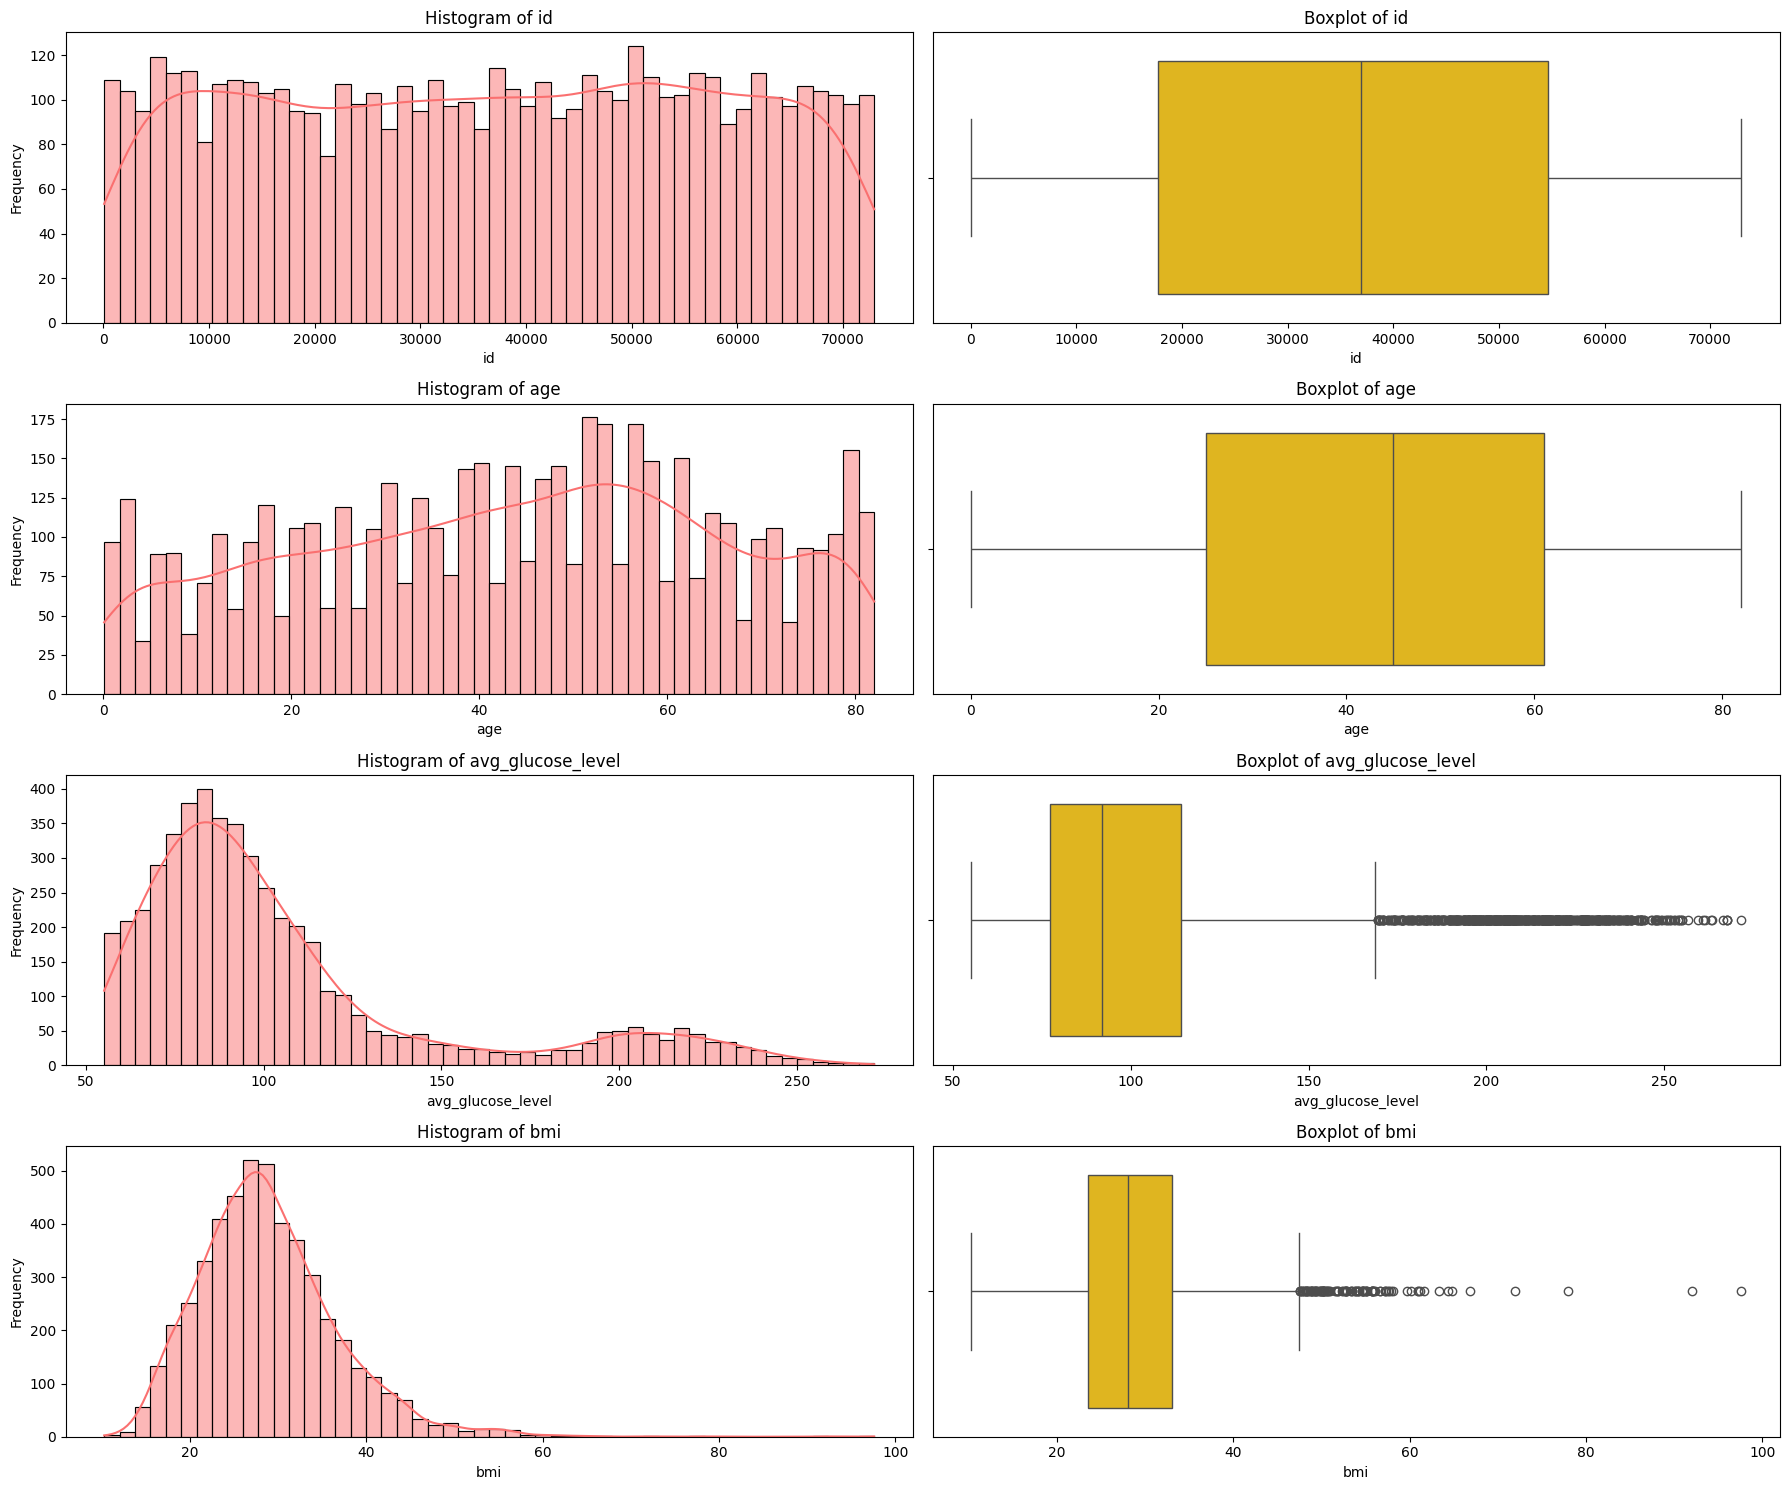

In [9]:
plt.figure(figsize=(18, 15))

for index, col in enumerate(numerical):
    # Histogram
    plt.subplot(len(numerical), 2, index * 2 + 1)
    sns.histplot(data[col], kde=True, color='#FA7070', bins=50)
    plt.title(f'Histogram of {col}', size=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(len(numerical), 2, index * 2 + 2)
    sns.boxplot(x=data[col], color='#FFC700')
    plt.title(f'Boxplot of {col}', size=12)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

**Correlation**

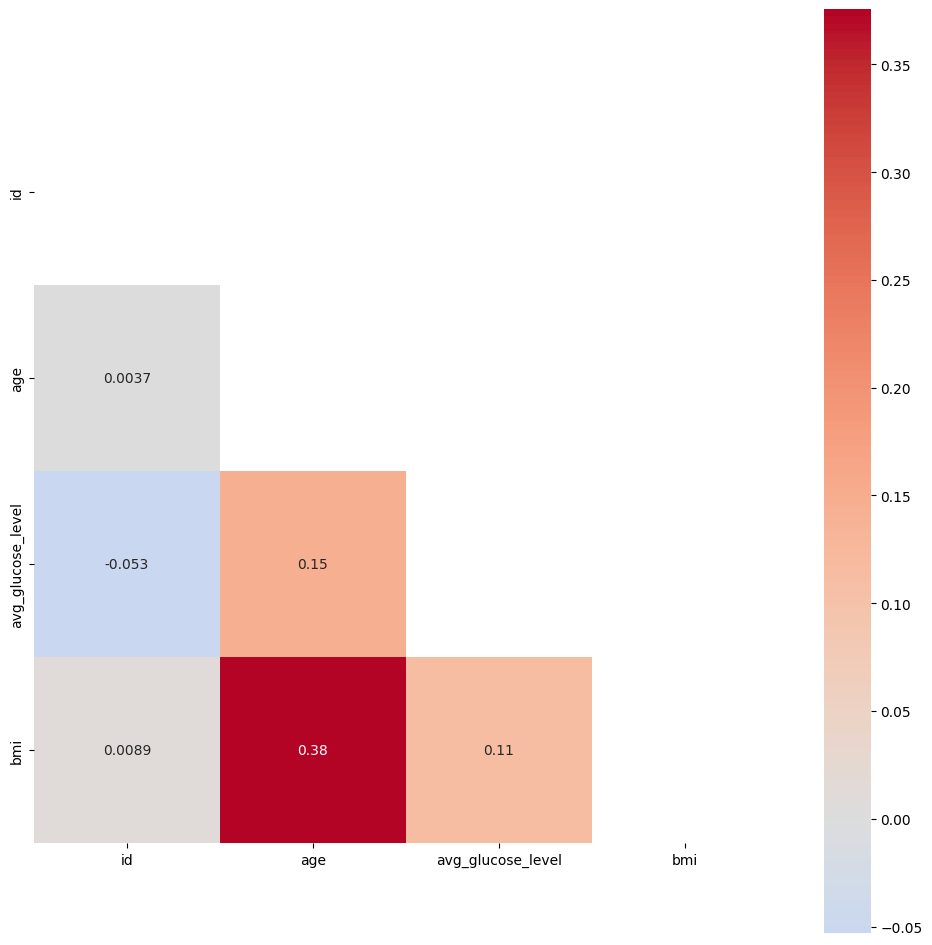

In [10]:
# Heatmap correlation (spearman)
plt.figure(figsize=(12, 12))

matrix = np.triu(data.select_dtypes(['int', 'float']).corr(method='spearman'))

sns.heatmap(data=data.select_dtypes(['int', 'float']).corr(method='spearman'), annot=True, cmap='coolwarm', center=0, mask = matrix, square='True')
plt.show()

**Feature vs Target**

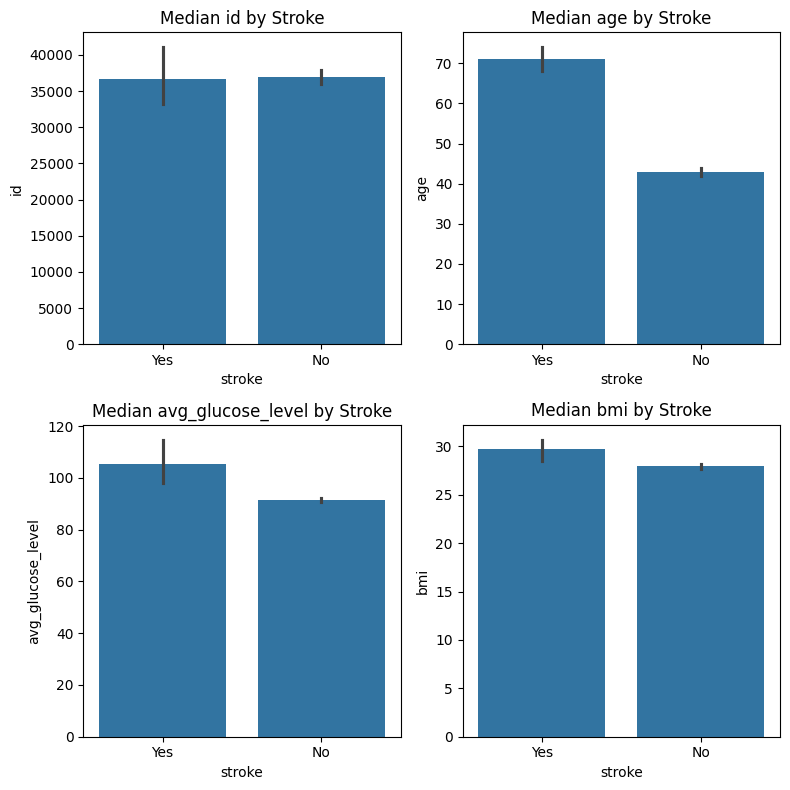

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for col, j in zip(numerical, axes.flatten()):
    ax = sns.barplot(data=data, y= col, x='stroke', estimator=np.median, ax= j)
    ax.set_title(f'Median {col} by Stroke')

plt.tight_layout()
plt.show()

#### `Categorical Features`

**Distribution**

In [12]:
categorical = [var for var in data.columns if data[var].dtypes in ['object']]

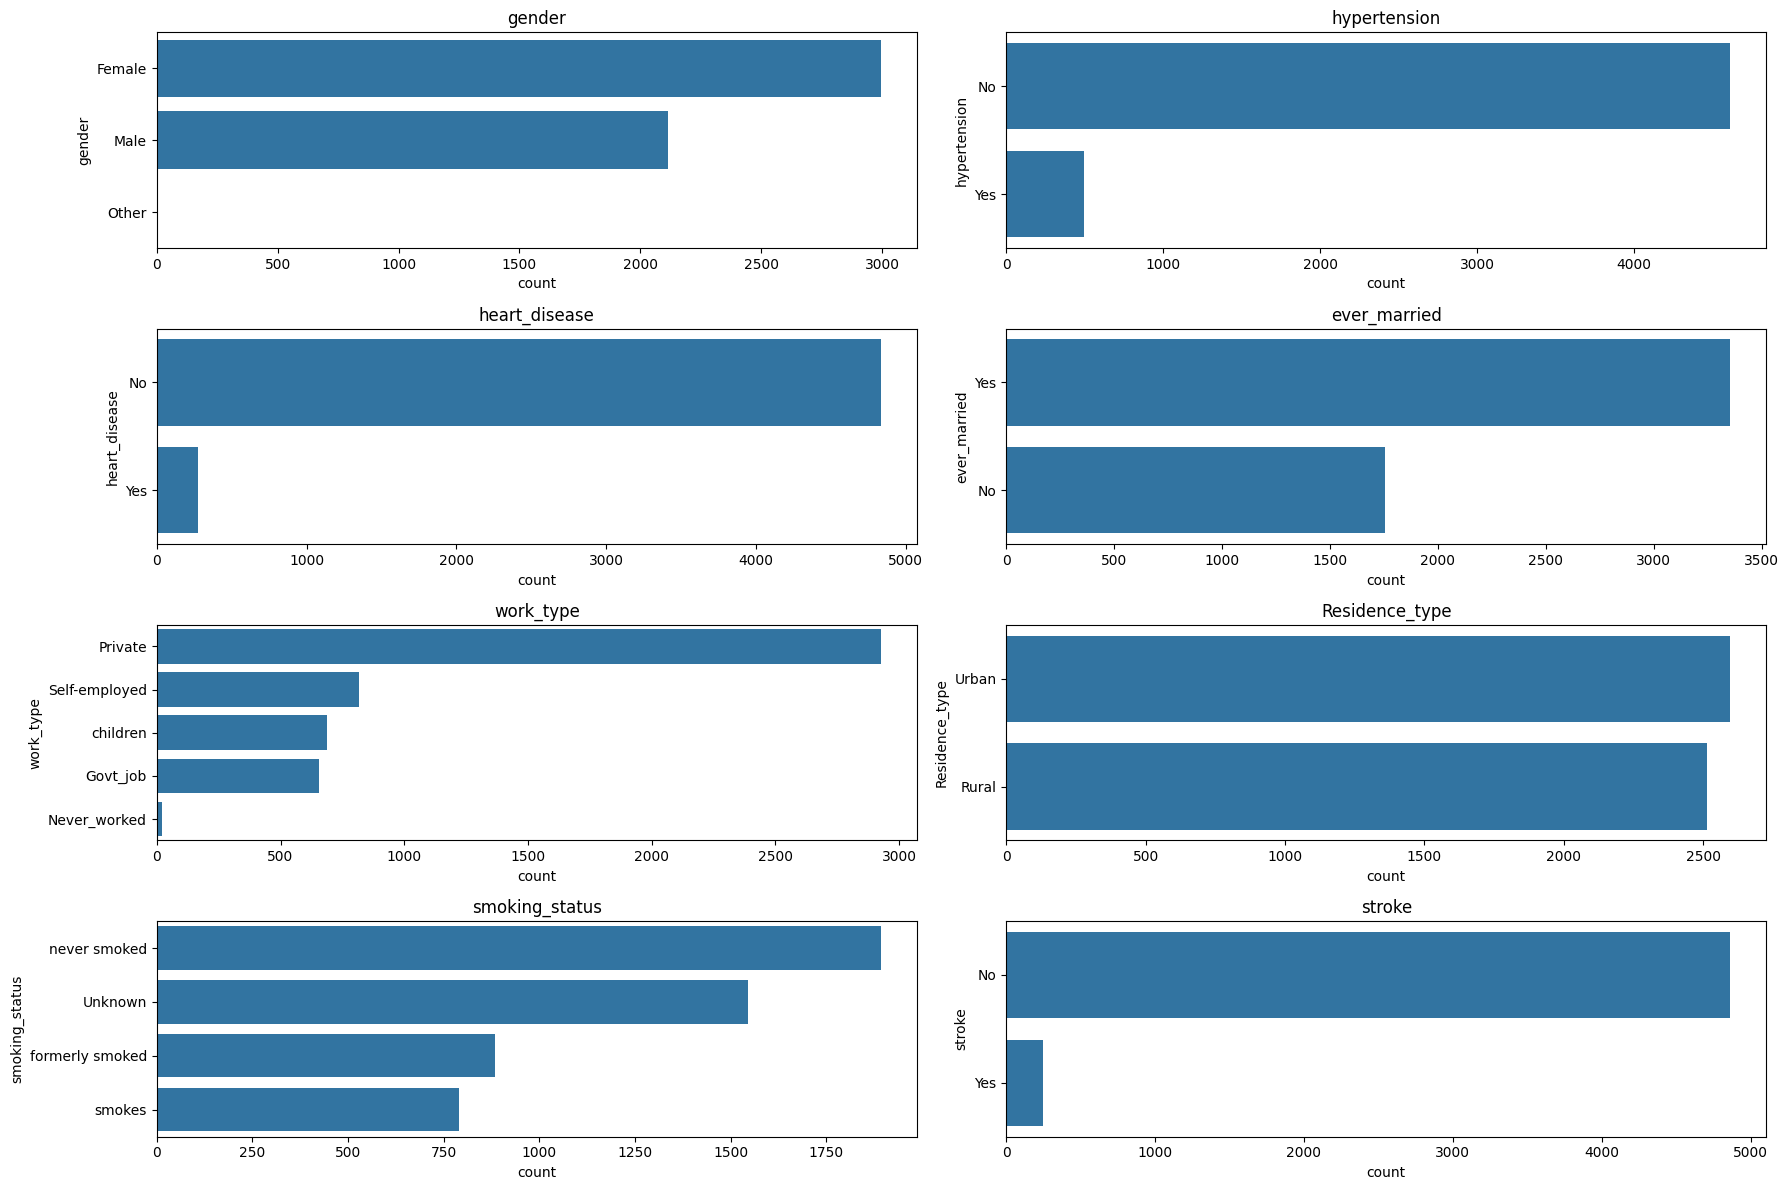

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(18, 12))
for i, j in zip(categorical, axes.flatten()):
    ax = sns.countplot(data=data, y= i, ax= j, order=data[i].value_counts().index)
    ax.set_title(f'{i}', size = 12)

plt.tight_layout()
plt.show()

**Feature vs Target**

In [14]:
def create_plot(data, col, x_maks=1000):

    agg_table = data.groupby([col, 'stroke']).size().unstack().reset_index()
    agg_table['total'] = agg_table['Yes']+agg_table['No']
    agg_table['% stroke'] = (agg_table['Yes']/agg_table['total']*100).round(2)
    agg_table = agg_table.sort_values(by='% stroke', ascending=False)
    agg_table

    fig, axes = plt.subplots(1, 2, figsize=(16,5))

    ax1 = sns.barplot(data=agg_table, y=col, x='% stroke', ax=axes[0])
    label = ['{:.1f} %'.format(x) for x in ax1.containers[0].datavalues]
    ax1.bar_label(ax1.containers[0], labels=label, padding=3, label_type='center')
    ax1.set_title(f'Percentage of stroke passengers by {col}')

    ax2 = sns.countplot(data=data, y=col, hue='stroke', order=agg_table[col], ax=axes[1])
    ax2.set_title(f'Number of passengers by {col} and claim')
    for container in ax2.containers:
        ax2.bar_label(container)
    ax2.set_xlim(0, x_maks)

    plt.tight_layout()
    plt.show()

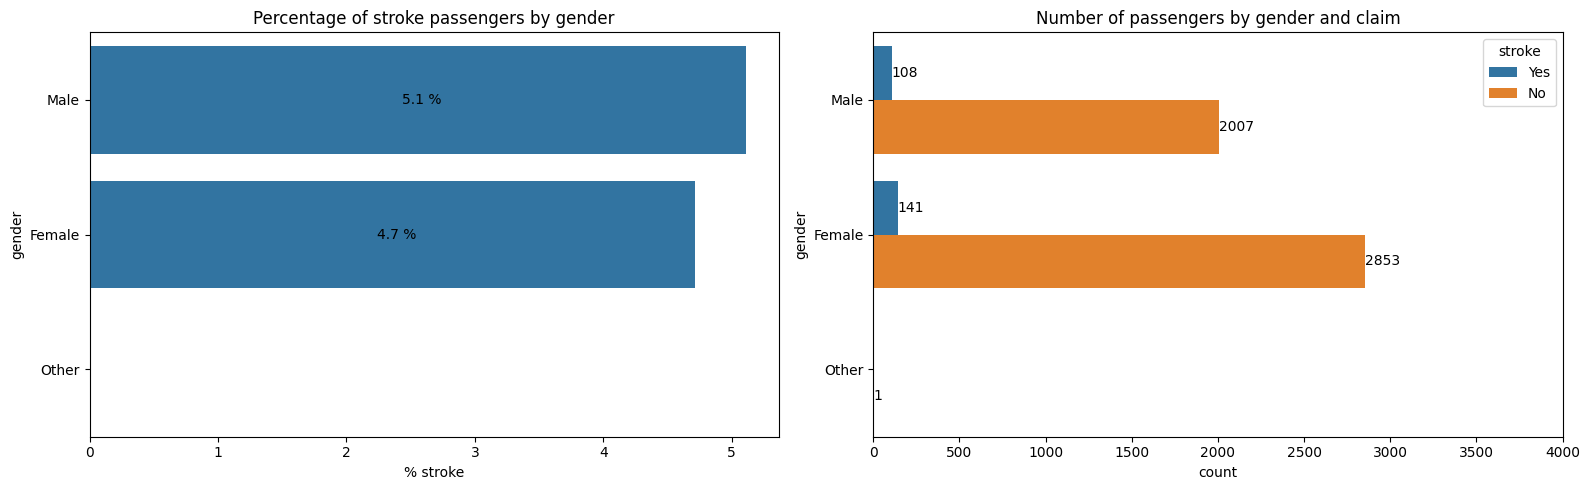

In [15]:
create_plot(data, 'gender', x_maks=4000)

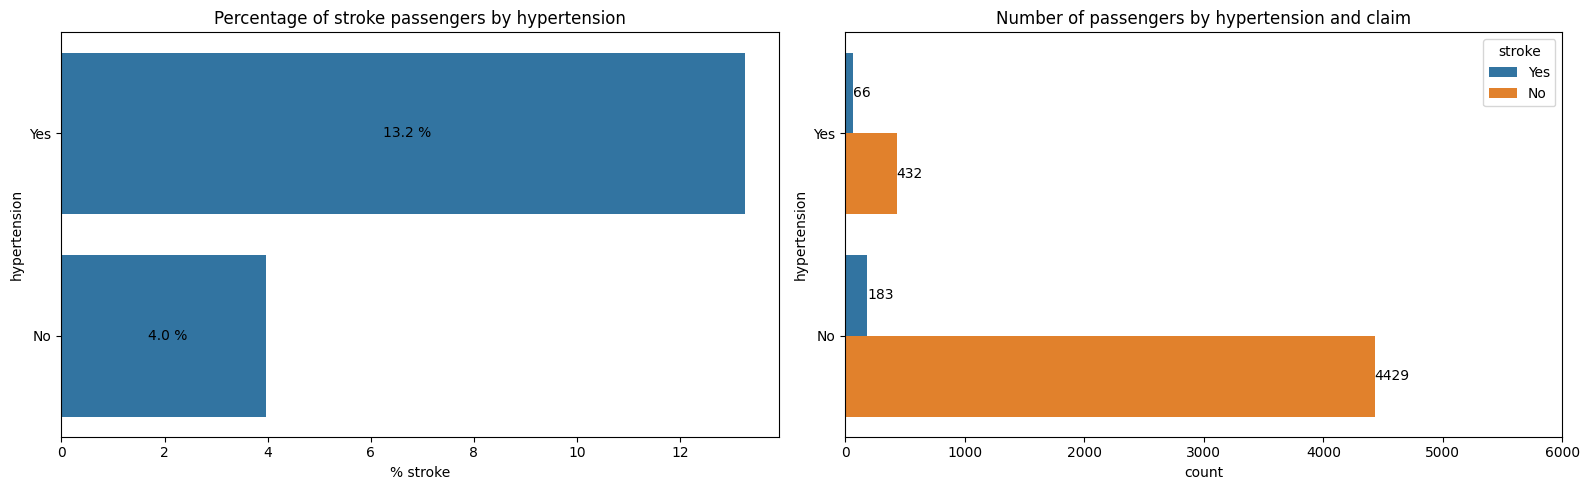

In [16]:
create_plot(data, 'hypertension', x_maks=6000)

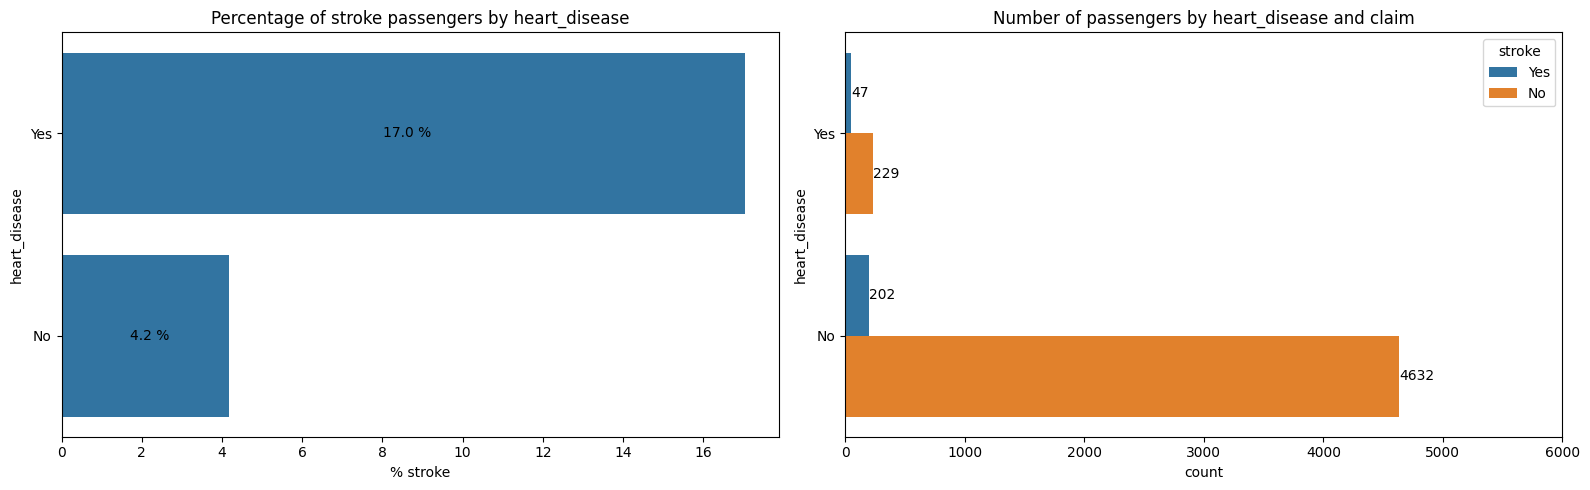

In [17]:
create_plot(data, 'heart_disease', x_maks=6000)

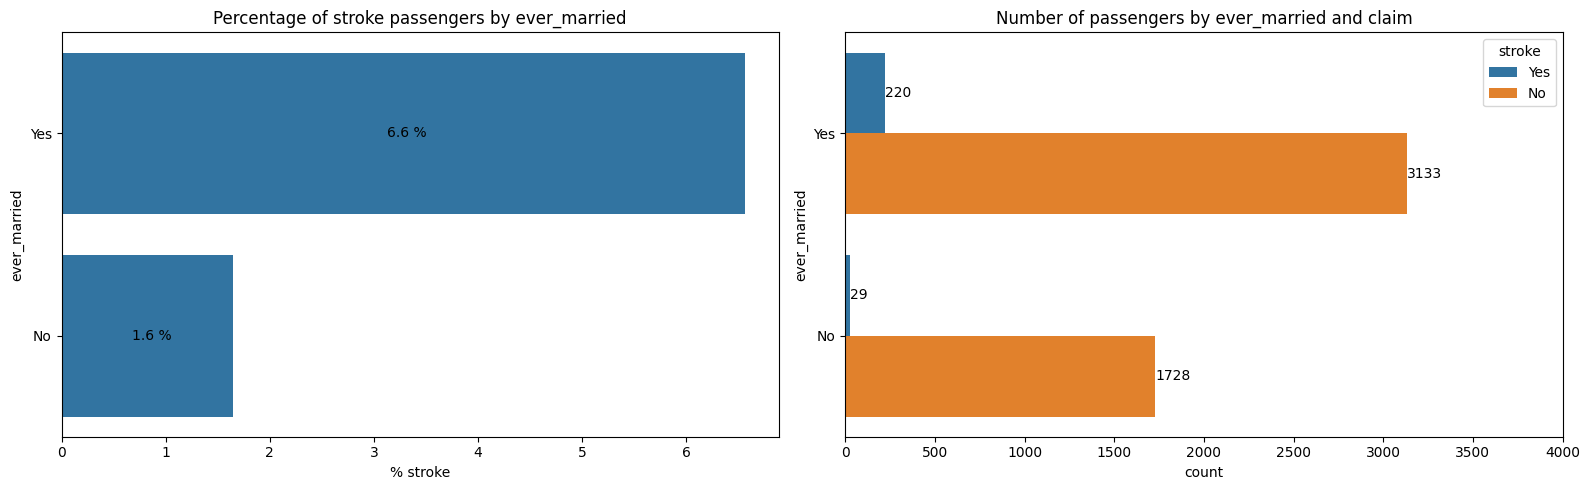

In [18]:
create_plot(data, 'ever_married', x_maks=4000)

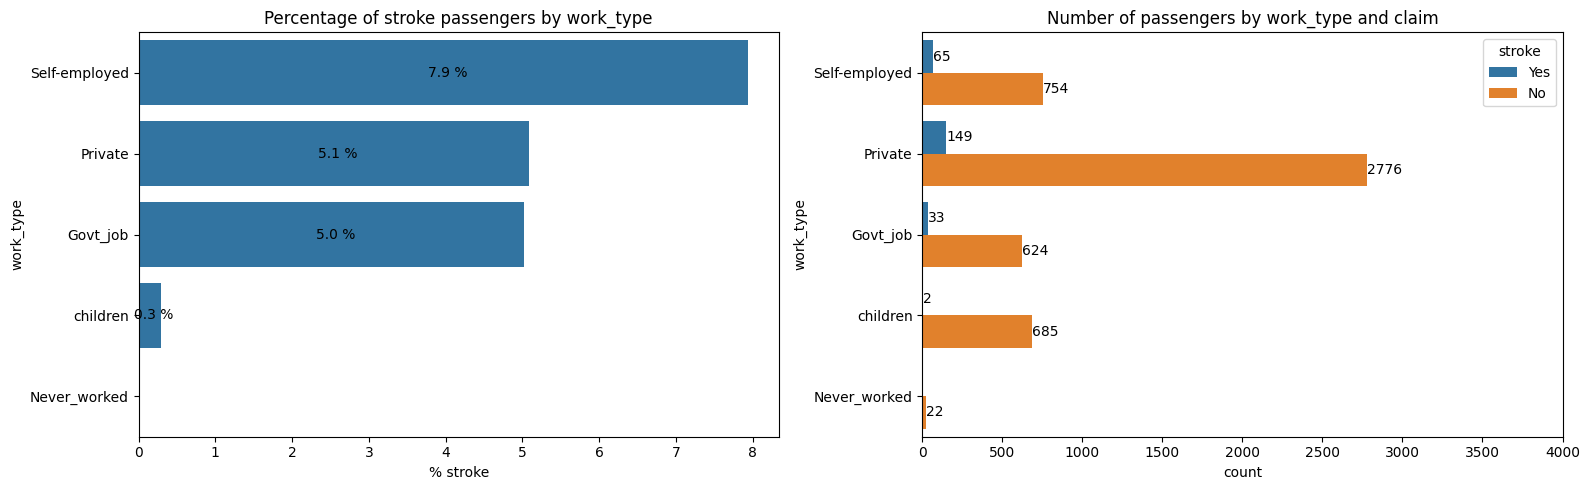

In [19]:
create_plot(data, 'work_type', x_maks=4000)

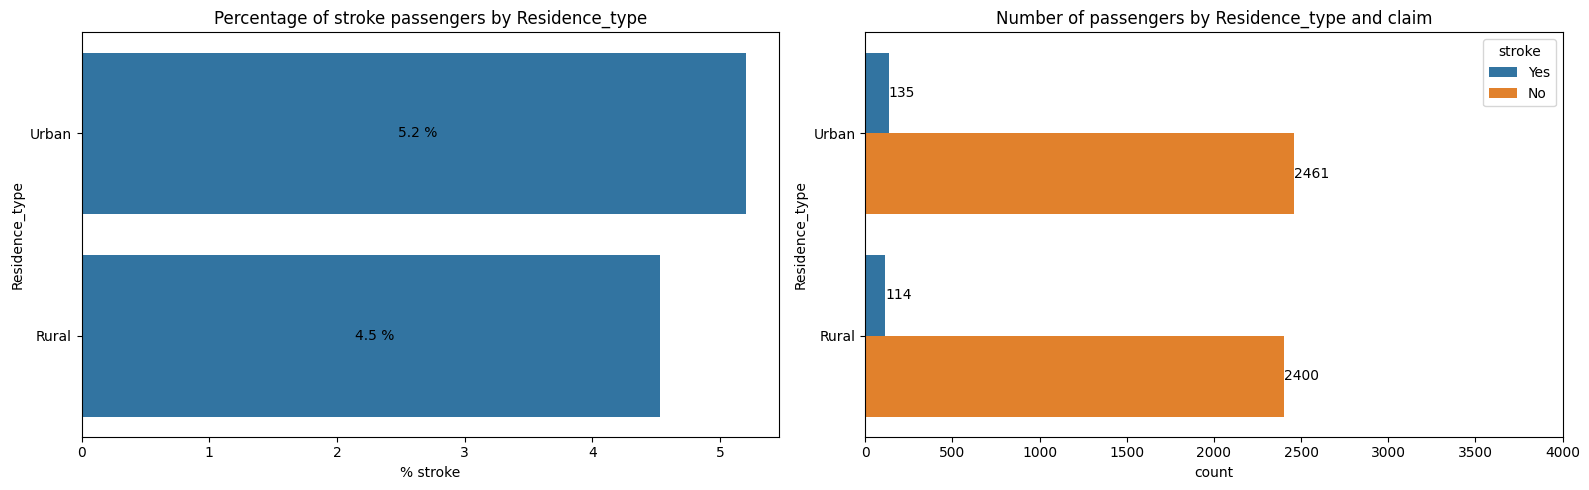

In [20]:
create_plot(data, 'Residence_type', x_maks=4000)

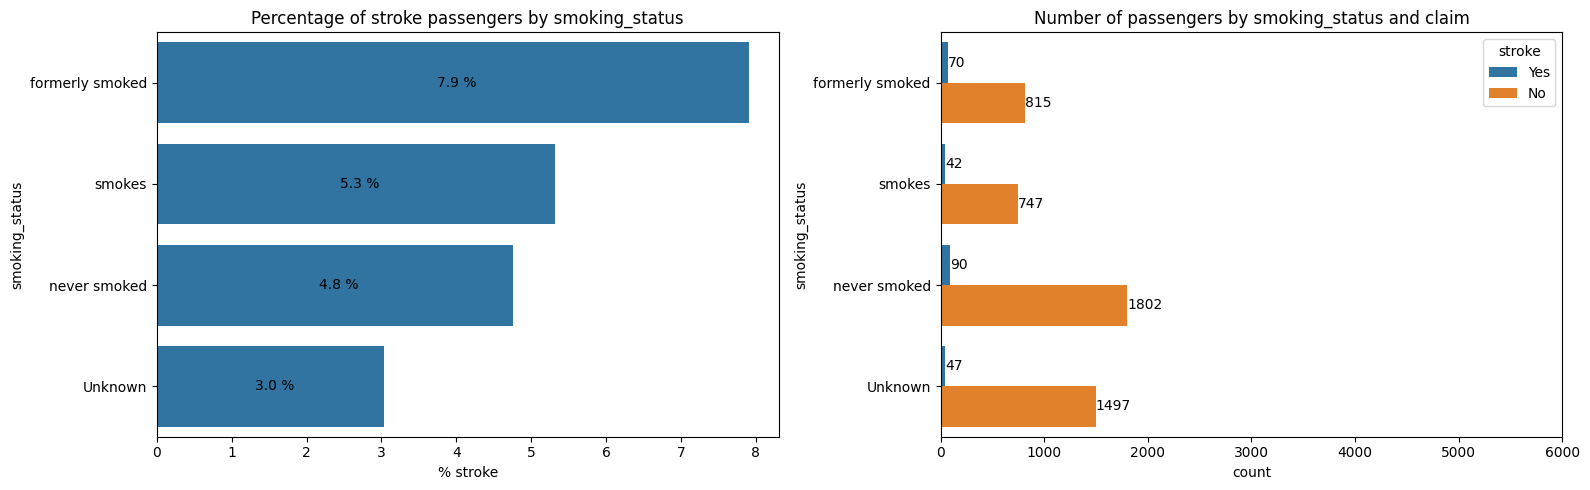

In [21]:
create_plot(data, 'smoking_status', x_maks=6000)

### **Data Preprocessing**

#### `Remove Unused Columns`

In [22]:
data.drop(columns=['id'], inplace=True)

#### `Duplicates`

In [23]:
print(f"Total duplicated data: {data[data.duplicated()].shape}")
print(f'Persentage: {len(data[data.duplicated()])/len(data)*100:.2f}%')

Total duplicated data: (0, 11)
Persentage: 0.00%


There are no duplicates

#### `Missing Values`

In [24]:
pd.DataFrame({'missing values': [data[col].isna().sum() for col in data.columns]}, index=data.columns.values)

,missing values
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0


There are missing values in the `BMI` feature

#### `Rare Labels`

There is a rare label in the `gender` feature with category of 'other'

In [25]:
def check_rare_label(col):
    temp_df = data[col].value_counts(normalize=True)

    plt.figure(figsize=(10, 5))
    fig = temp_df.plot.bar(rot=90)
    fig.set_xlabel(col)
    fig.set_ylabel(f'Percentage of {col}')
    fig.set_title(f'Proportion of {col}')

    plt.axhline(y=0.05, color='red', linestyle='--')
    plt.show()

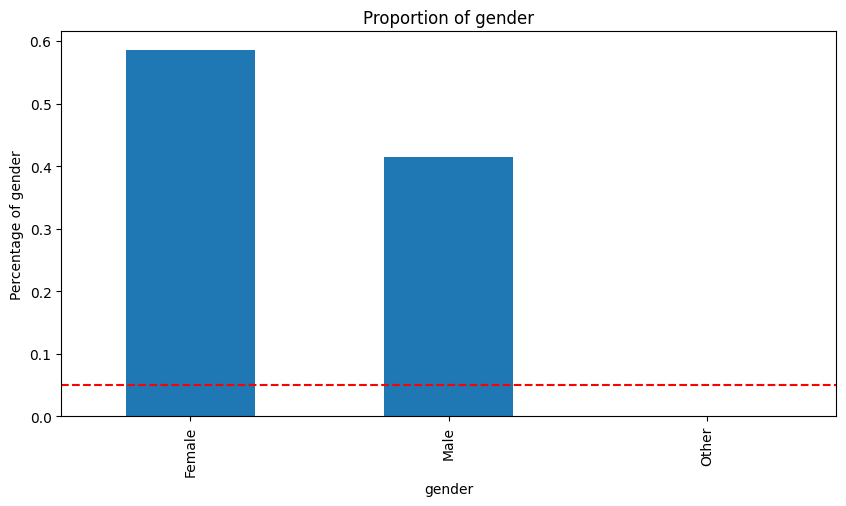

In [26]:
check_rare_label('gender')

In [27]:
data[data['gender']=='Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,No,No,No,Private,Rural,143.33,22.4,formerly smoked,No


In [28]:
# Drop rare label 'Other' in gender
data = data.drop(index=3116)

#### `Imbalance Data`

In [29]:
# Check the class distribution
from collections import Counter

print("Class distribution:", Counter(data['stroke']))

Class distribution: Counter({'No': 4860, 'Yes': 249})


In [30]:
# Percentage of imbalance data
data['stroke'].value_counts(normalize=True)

,proportion
stroke,
No,0.951262
Yes,0.048738


These data proportion can be categorized as heavily imbalance.

#### `Outliers`

In [31]:
def calculate_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_data = []

numerical = [var for var in data.columns if data[var].dtypes != 'object']

for column in numerical:
    outlier_result, lower_bound, upper_bound = calculate_outliers(data, column)
    total_outlier = len(outlier_result)
    outlier_percentage = round(total_outlier / len(data[column]) * 100, 2)
    outlier_data.append([column, total_outlier, outlier_percentage, lower_bound, upper_bound])

outlier_df = pd.DataFrame(outlier_data, columns=["Column", "Total Outliers", "Percentage (%)", "Lower Bound", "Upper Bound"])
outlier_df

,Column,Total Outliers,Percentage (%),Lower Bound,Upper Bound
0,age,0,0.00,-29.000,115.000
1,avg_glucose_level,627,12.27,21.965,169.365
2,bmi,110,2.15,9.100,47.500


There are outliers in the numerical column with percentages ranging from 0% to 12.27%. We will examine the proportion of targets in these outlier data.

In [32]:
proportion = []
indeces = []

for i, row in outlier_df.iterrows():
    outlier = data[(data[row['Column']] < row['Lower Bound']) | (data[row['Column']] > row['Upper Bound'])]
    percentages = (outlier['stroke'].value_counts(normalize=True)*100).values
    proportion.append(percentages)
    indeces.append(row['Column'])

pd.DataFrame(proportion, columns=['Not Stroke', 'Stroke'], index=indeces)

,Not Stroke,Stroke
age,NaN,NaN
avg_glucose_level,86.602871,13.397129
bmi,98.181818,1.818182


#### `Collinearity`

In [33]:
def calculate_vif(data):
    vif = pd.DataFrame()
    vif['Feature'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.dropna(), i) for i in range(len(data.columns))]

    return vif.sort_values('VIF', ascending=False)

We will carry out repeated testing until we obtain a VIF value < 10.

In [34]:
vif_df = calculate_vif(data[numerical])
dropped_columns = []

for i in range(len(vif_df)):
    if vif_df.iloc[0, -1] < 10:
        break
    else:
        dropped_columns.append(vif_df.iloc[0, 0])
        vif_df = calculate_vif(data[numerical].drop(columns=dropped_columns))

In [35]:
vif_df

,Feature,VIF
2,bmi,7.940739
1,avg_glucose_level,6.008471
0,age,5.340590


In [36]:
dropped_columns

[]

There is no multicolinearity observed

#### `Cardinality`

In [37]:
categorical = [var for var in data.drop(columns='stroke').columns if data[var].dtypes == 'object']

In [38]:
# creating a function to check cardinality
def check_cardinality(data):
    for feature in categorical:
        cardinality = len(data[feature].unique())
        print(f"Cardinality of {feature}: {cardinality}")

        if cardinality > 10:
            print(f"Warning: High cardinality in {feature}.")

check_cardinality(data)

Cardinality of gender: 2
Cardinality of hypertension: 2
Cardinality of heart_disease: 2
Cardinality of ever_married: 2
Cardinality of work_type: 5
Cardinality of Residence_type: 2
Cardinality of smoking_status: 4


#### `Feature Engineering`

**Handling missing values**

To handle missing values ​​in the bmi column, we will try using IterativeImputer based on other columns.

**Encoding**

Now let's encode our categorical features.
Here's what we'll do:

1. Transform the features/columns `gender, hypertension, heart_disease, ever_married, work_type, residence_type, and smoking_status` using One Hot Encoding, as these features are not ordinal and contain only a small number of unique data points.

**Scaling**

We will use the Robust Scaler because our data contains outliers, and the Robust Scaler will not be affected by outliers. We can re-adjust the scaler later to find the best scaler.

**Imbalance Data**

We can see that the dataset is moderately imbalanced because the minority class proportion is 4.8%.

To address this, we can test whether the modeling requires a resampling method to ensure a more balanced class distribution.

We will compare some of resampling methods, to find the best one to use.

### **Modeling**

#### `Define Features (X) and Target (y)`

In [39]:
data['stroke'] = np.where(data['stroke']=='Yes', 1, 0)

In [40]:
# Define features and target
# feature
X = data.drop(columns='stroke')

# target
y = data['stroke']

#### `Data Splitting`

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

#### `Pipeline`

| Technique | Action |
| ----------------------------- | ----------- |
| Iterative Imputer | Imputing the `bmi` column based on other columns using regression |
| One Hot Encoding | Transforming the `gender, hypertension, heart_disease, ever_married, work_type, residence_type, and smoking_status` columns with the number of unique values ​​<= 10 |
| Robust Scaling | Scaling transformation of each feature using a robust scaler |
| SMOTE | Resampling the training data due to imbalanced targets |

In [42]:
# Column Transformer
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['gender', 'hypertension', 'heart_disease', 'ever_married','work_type','Residence_type', 'smoking_status']),
], remainder='passthrough')

In [43]:
# Handling missing value
imputer = IterativeImputer()

In [44]:
# Scaling
scaler = RobustScaler()

In [45]:
# Resampling
smote = SMOTE(random_state=0)
rus = RandomUnderSampler(random_state=0)
ros = RandomOverSampler(random_state=0)

resamplers = [rus, ros, smote]

#### `Model Selection`

In [46]:
# Define the models
logreg = LogisticRegression(solver='liblinear', random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
dtree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)

In [47]:
# Model selection
models = [logreg, knn, dtree]
resamplers = [rus, ros, smote]

recall_mean = []
recall_std = []
all_recall = []
model_name = []
resampler_name = []

# Finding the best model based on the best recall score and the smallest standard deviation
for algoritma in models:
    for resampler in resamplers:

        model_pipe = Pipeline([
            ('preprocessing', transformer),
            ('imputer', imputer),
            ('scaler', scaler),
            ('resampler', resampler),
            ('model', algoritma)
        ])

        skfold = StratifiedKFold(n_splits = 5)

        model_cv = cross_val_score(
            model_pipe,                 # model inside pipeline
            X_train,                    # data before preprocessing
            y_train,
            cv = skfold,
            scoring = 'recall',
            error_score='raise'
            )

        recall_mean.append(model_cv.mean())
        recall_std.append(model_cv.std())
        all_recall.append(model_cv.round(4))
        model_name.append(algoritma.__class__.__name__)
        resampler_name.append(resampler.__class__.__name__)

In [48]:
# Comparison of recall scores
pd.DataFrame({
    'model': model_name,
    'resampler': resampler_name,
    'mean': recall_mean,
    'std': recall_std,
    'all_score' : all_recall
})

,model,resampler,mean,std,all_score
0,LogisticRegression,RandomUnderSampler,0.793974,0.042941,"[0.875, 0.775, 0.7949, 0.775, 0.75]"
1,LogisticRegression,RandomOverSampler,0.788846,0.068483,"[0.9, 0.825, 0.7692, 0.75, 0.7]"
2,LogisticRegression,SMOTE,0.773462,0.077397,"[0.9, 0.825, 0.6923, 0.725, 0.725]"
3,KNeighborsClassifier,RandomUnderSampler,0.708077,0.049917,"[0.725, 0.75, 0.6154, 0.75, 0.7]"
4,KNeighborsClassifier,RandomOverSampler,0.261410,0.021219,"[0.275, 0.225, 0.2821, 0.25, 0.275]"
5,KNeighborsClassifier,SMOTE,0.366667,0.055025,"[0.425, 0.4, 0.3333, 0.4, 0.275]"
6,DecisionTreeClassifier,RandomUnderSampler,0.874359,0.027416,"[0.825, 0.9, 0.8718, 0.875, 0.9]"
7,DecisionTreeClassifier,RandomOverSampler,0.759231,0.096249,"[0.85, 0.8, 0.8462, 0.7, 0.6]"
8,DecisionTreeClassifier,SMOTE,0.657051,0.138999,"[0.7, 0.825, 0.4103, 0.625, 0.725]"


*Predict Benchmark Model to Test Set*

In [49]:
list_recall = []
list_resample = []

# # Finding the best model based on the best recall score and the smallest standard deviation
for algoritma in models :
    for resampler in resamplers:

        model_pipe = Pipeline([
            ('preprocessing', transformer),
            ('imputer', imputer),
            ('scaler', scaler),
            ('resampler', resampler),
            ('model', algoritma)
        ])

        # fitting
        model_pipe.fit(X_train, y_train)

        # predict
        y_pred = model_pipe.predict(X_test)

        # evaluate
        score = recall_score(y_test, y_pred)
        list_recall.append(score)
        list_resample.append(resampler)

In [50]:
# Performance comparison among models
pd.DataFrame({
    'model': model_name,
    'resampler': list_resample,
    'accuracy (test_set)': list_recall
})

,model,resampler,accuracy (test_set)
0,LogisticRegression,RandomUnderSampler(random_state=0),0.80
1,LogisticRegression,RandomOverSampler(random_state=0),0.68
2,LogisticRegression,SMOTE(random_state=0),0.68
3,KNeighborsClassifier,RandomUnderSampler(random_state=0),0.76
4,KNeighborsClassifier,RandomOverSampler(random_state=0),0.26
5,KNeighborsClassifier,SMOTE(random_state=0),0.28
6,DecisionTreeClassifier,RandomUnderSampler(random_state=0),0.70
7,DecisionTreeClassifier,RandomOverSampler(random_state=0),0.72
8,DecisionTreeClassifier,SMOTE(random_state=0),0.66


**Insight**

* The most stable model was Logistic Regression with Random Undersampling on both the train and test data sets.
From now on, only the Logistic Regression model will be tuned.

#### `Hyperparameter Tuning`

In [51]:
# Hyperparameters for the model (logistic regression)
param_grid = {
'model__C':[100, 10, 1, 0.1, 0.01, 0.001],
'model__solver':['liblinear','newton-cg', 'sag'],
}

In [52]:
# model benchmark
logreg = LogisticRegression(solver='liblinear')

# model inside pipeline
logreg_pipeline = Pipeline([
    ('preprocessing', transformer),
    ('imputer', imputer),
    ('scaler', scaler),
    ('resampler', rus),
    ('model', logreg)
])

# Grid search (find the best parameters)
tuned_model = GridSearchCV(
    estimator = logreg_pipeline,
    param_grid = param_grid,
    cv = skfold,
    scoring = 'recall',
    n_jobs= -1,
)

# fit tuned_model on train set
tuned_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['gender',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'ever_married',
                                                                          'work_type',
                                                                          'Residence_type',
                                                                          'smoking_status'])])),
                                       ('imputer', IterativeImputer()),
                                       ('scaler', RobustScaler()),
                                       ('resampler',
                                        RandomUnderSampler(random_state=0)),
                                       ('model',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'model__solver': ['liblinear', 'newton-cg', 'sag']},
             scoring='recall')

In [53]:
# Best recall score (grid_search)
print(f'Recall Score on the train set: {tuned_model.best_score_:.3f}')

# Best hyperparameter from tuned_model
print(f'Best parameters: {tuned_model.best_params_}')

Recall Score on the train set: 0.900
Best parameters: {'model__C': 0.001, 'model__solver': 'liblinear'}


In [54]:
pd.DataFrame(tuned_model.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.402302,0.021752,0.019007,0.001497,0.001,liblinear,"{'model__C': 0.001, 'model__solver': 'liblinear'}",0.950,0.925,1.000000,0.775,0.85,0.900000,0.079057,1
12,0.412975,0.016468,0.020527,0.003137,0.010,liblinear,"{'model__C': 0.01, 'model__solver': 'liblinear'}",0.925,0.900,0.923077,0.775,0.80,0.864615,0.064066,2
9,0.660072,0.071174,0.039066,0.002697,0.100,liblinear,"{'model__C': 0.1, 'model__solver': 'liblinear'}",0.875,0.825,0.846154,0.825,0.80,0.834231,0.025086,3
10,0.660045,0.092575,0.030010,0.008647,0.100,newton-cg,"{'model__C': 0.1, 'model__solver': 'newton-cg'}",0.900,0.825,0.820513,0.750,0.80,0.819103,0.048417,4
11,0.449204,0.073876,0.024887,0.009873,0.100,sag,"{'model__C': 0.1, 'model__solver': 'sag'}",0.900,0.825,0.820513,0.750,0.80,0.819103,0.048417,4


*Predict Tuned Model to Test Set*

In [55]:
tuned_model.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married', 'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('imputer', IterativeImputer()), ('scaler', RobustScaler()),
                ('resampler', RandomUnderSampler(random_state=0)),
                ('model', LogisticRegression(C=0.001, solver='liblinear'))])

In [56]:
# Model after hyperparameter tuning
best_model = tuned_model.best_estimator_

# Fitting model
best_model.fit(X_train, y_train)

# Predict to test set
y_pred_best = best_model.predict(X_test)

# Evaluate recall score on test set
print(f'Recall scoreon the test set: {recall_score(y_test, y_pred_best):.3f}')

Recall scoreon the test set: 0.760


| MAE Score | Train Set | Test Set |
| --- | --- | --- |
| Before Tuning | 0.793 | 0.800 |
| After Tuning | 0.900 | 0.760 |

- The model selected for modeling this dataset is Logistic Regression.
- Hyperparameter tuning did not improve the performance of the Logistic Regression model based on recall score, although not significantly.
- The best hyperparameters based on GridSearch were **{'model__C': 0.001, 'model__solver': 'liblinear'}**

#### `Model Evaluation`

**Coefficients**

In [57]:
onehot_features = list(best_model['preprocessing'].transformers_[0][1].get_feature_names_out())
remainder_features = list(X.columns[best_model['preprocessing'].transformers_[1][2]])

feature_names = onehot_features + remainder_features

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


In [58]:
df_coef = pd.DataFrame({
    "feature" : feature_names,
    "coefficient" : best_model['model'].coef_[0]
}).sort_values(by='coefficient', ascending=False)

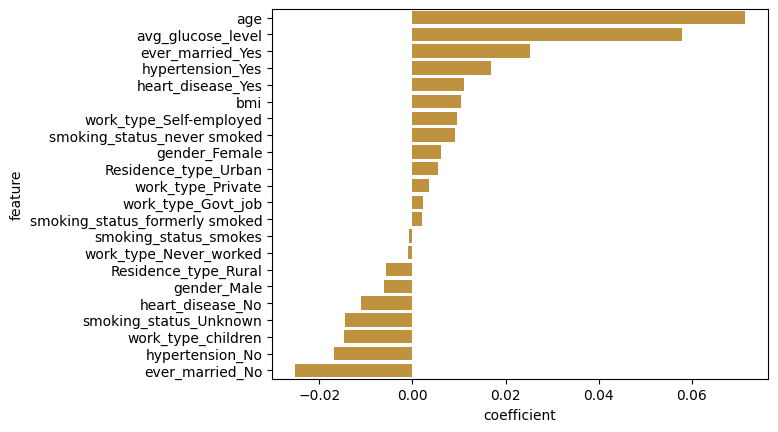

In [59]:
sns.barplot(data=df_coef, x='coefficient', y='feature', color='orange', saturation=0.5)
plt.show()

**Classification report**

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.74      0.84       972
           1       0.12      0.66      0.20        50

    accuracy                           0.74      1022
   macro avg       0.55      0.70      0.52      1022
weighted avg       0.93      0.74      0.81      1022



**PR-Curve**

Best Threshold=0.5242159901698812


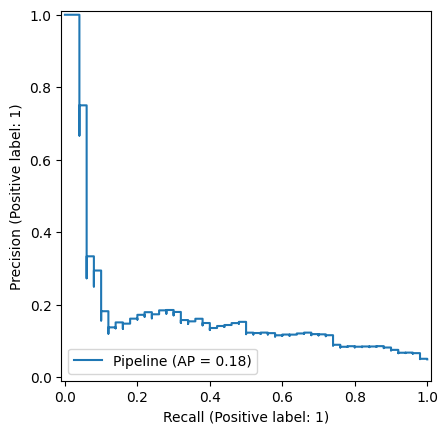

In [61]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:,1])
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}')

PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

In [62]:
y_proba = best_model.predict_proba(X_test)[:,1]

In [63]:
df_proba = pd.DataFrame(y_test)
df_proba['probability'] = y_proba

In [64]:
def probability_range(x):
    if x < 0.1:
        probability_range = '0.0 - 0.1'
    elif 0.1 <= x < 0.2:
        probability_range = '0.1 - 0.2'
    elif 0.2 <= x < 0.3:
        probability_range = '0.2 - 0.3'
    elif 0.3 <= x < 0.4:
        probability_range = '0.3 - 0.4'
    elif 0.4 <= x < 0.5:
        probability_range = '0.4 - 0.5'
    elif 0.5 <= x < 0.6:
        probability_range = '0.5 - 0.6'
    elif 0.6 <= x < 0.7:
        probability_range = '0.6 - 0.7'
    elif 0.7 <= x < 0.8:
        probability_range = '0.7 - 0.8'
    elif 0.8 <= x < 0.9:
        probability_range = '0.8 - 0.9'
    else:
        probability_range = '0.9 - 1.0'

    return probability_range

df_proba.insert(1, 'probability range',value ='')

df_proba['probability range'] = df_proba['probability'].apply(probability_range)

In [65]:
df_probability = df_proba.groupby(['probability range', 'stroke']).size().unstack().reset_index()
df_probability['total'] = df_probability[1]+df_probability[0]
df_probability['actual probability'] = (df_probability[1]/df_probability['total']).round(2)
df_probability['predicted probability'] = df_proba.groupby(['probability range'])['probability'].mean().values.round(2)
df_probability = df_probability.sort_values(by='probability range', ascending=False)
df_probability = df_probability.rename(columns = {0:'no', 1:'yes'})
df_probability

stroke,probability range,no,yes,total,actual probability,predicted probability
1,0.5 - 0.6,416,38,454,0.08,0.52
0,0.4 - 0.5,556,12,568,0.02,0.48


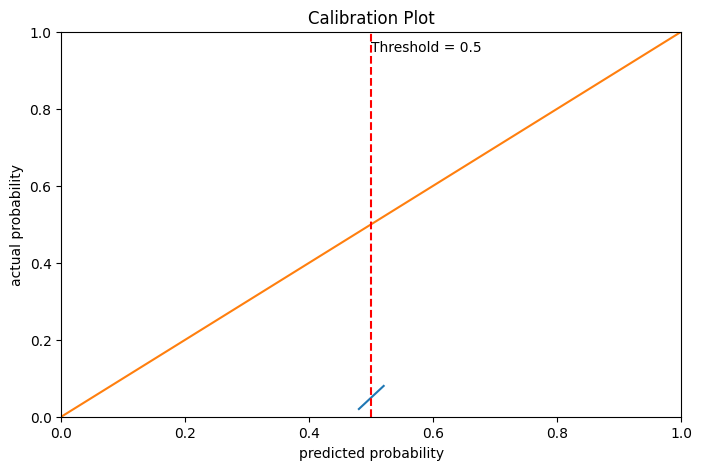

In [66]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df_probability.sort_values(by='probability range', ascending=True), x='predicted probability', y='actual probability')
value = [x/100 for x in range(0,110,10)]
sns.lineplot(x=value, y=value)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axvline(0.5, color='r', linestyle='--')
plt.annotate('Threshold = 0.5', (0.5,0.95))
plt.title('Calibration Plot')
plt.show()

**Confusion matrix**

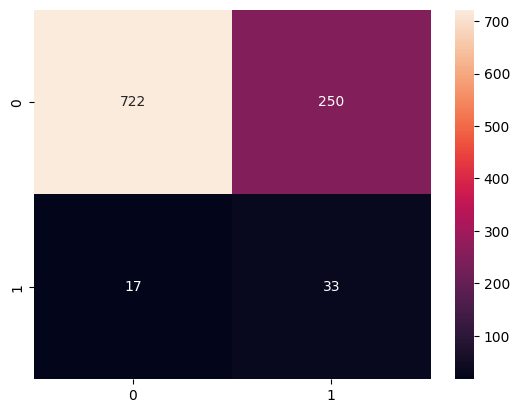

In [67]:
confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g');